In [1]:
%matplotlib inline 
import xarray as xr
import os 
import pandas as pd
import numpy as np

In [2]:
import dask
import dask.array as dda
import dask.dataframe as ddf
import dask.distributed as dd
import dask_kubernetes as dk
import rhg_compute_tools.utils as rhgu
import rhg_compute_tools.kubernetes as rhgk

import intake

In [3]:
import xesmf as xe

In [ ]:
# !pip install --upgrade --upgrade-strategy=only-if-needed intake-esm
# !pip install pydap

This notebook implements a scaling test for bias correction, using the BCSDTemperature model from `scikit-downscale`, with the daily BCSD bias correction method as implemented in the NASA-NEX dataset. 

Datasets used include a CMIP6 model from a historical run (`GISS-E2-1-G` from NASA) and GMFD (obs). Historical/training period is taken as 1980-1982, and the future/predict period is 1990-1991. 

GMFD is coarsened to the NASA `GISS-E2-1-G` grid for this bias correction test. 

Note that the purpose of this notebook is intended to allow us to get a better estimate of timing for global daily bias correction. Future work will build on this notebook to: 
- replace GMFD with ERA5
- combine this notebook with `SD_prototype.ipynb`, along with NASA-NEX data and a corresponding CMIP5 model, and over a limited domain, to test our implementation of BCSD against NASA-NEX for a limited domain. That notebook will be used as a prototype for our downscaling pipeline and can be modified to become a system test for the pipeline (1-3 gridcells for CI/CD, limited domain for science testing). 

In [4]:
client, cluster = rhgk.get_standard_cluster(extra_pip_packages="git+https://github.com/dgergel/xsd.git@feature/implement_daily_bcsd")
cluster

In [5]:
def _convert_lons(ds, lon_name='longitude'):
    '''
    converts longitudes from 0 to 360 to -180 to 180
    '''
    ds_conv_coords = ds.assign_coords(longitude=(((ds[lon_name] + 180) % 360) - 180))
    ds_sort = ds_conv_coords.sel(**{lon_name: np.sort(ds_conv_coords[lon_name].values)})
    return(ds_sort)

note that this workflow is modeled after Section 2.4 from `https://github.com/jhamman/scikit-downscale/blob/ecahm2020/examples/2020ECAHM-scikit-downscale.ipynb`, with key differences being: 
- obs dataset
- regridding methods
- downscaling method (using NASA-NEX method for quantile mapping versus the more traditional monthly one)

In [6]:
train_slice = slice('1980', '1982')  # train time range
holdout_slice = slice('1990', '1991')  # prediction time range

# bounding box of downscaling region
lon_slice = slice(-124.8, -120.0) 
lat_slice = slice(50, 45)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

In [7]:
'''# obs subset from Joe's example 
fnames = [f'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/tmmx/tmmx_{year}.nc'
          for year in range(int(train_slice.start), int(train_slice.stop) + 1)]
# open the data and cleanup a bit of metadata
obs = xr.open_mfdataset(fnames, engine='pydap', concat_dim='day').rename({'day': 'time'}).drop('crs')

obs_subset = obs['air_temperature'].sel(time=train_slice, lon=lon_slice, lat=lat_slice).resample(time='1d').mean(
             ).load(scheduler='threads').chunk(chunks)'''

"# obs subset from Joe's example \nfnames = [f'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/tmmx/tmmx_{year}.nc'\n          for year in range(int(train_slice.start), int(train_slice.stop) + 1)]\n# open the data and cleanup a bit of metadata\nobs = xr.open_mfdataset(fnames, engine='pydap', concat_dim='day').rename({'day': 'time'}).drop('crs')\n\nobs_subset = obs['air_temperature'].sel(time=train_slice, lon=lon_slice, lat=lat_slice).resample(time='1d').mean(\n             ).load(scheduler='threads').chunk(chunks)"

use GMFD since obs data above is just for the PNW

In [8]:
tmax_obs = xr.open_mfdataset(os.path.join('/gcs/rhg-data/climate/source_data/GMFD/tmax', 
                                         'tmax_0p25_daily_198*'), concat_dim='time', combine='nested',
                              parallel=True).squeeze(drop=True)

# standardize longitudes 
tmax_obs = _convert_lons(tmax_obs)

# remove leap days 
tmax_obs = tmax_obs['tmax'].sel(time=~((tmax_obs.time.dt.month == 2) & (tmax_obs.time.dt.day == 29)))

note that here the obs data needs to be actually loaded for regridding to occur _before_ downscaling (future workflow needs to do this on workers)

In [9]:
gmfd_chunks = {'latitude': 10, 'longitude': 10, 'time': -1}
# obs_subset = tmax_obs.sel(time=train_slice).load(scheduler='threads').chunk(gmfd_chunks)
obs_subset = tmax_obs.sel(time=train_slice).load()

In [10]:
# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='day', variable_id='tasmax',
                 grid_label='gn')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
# access the data and do some cleanup
ds_model = cat['CMIP.NASA-GISS.GISS-E2-1-G.historical.day.gn'].to_dask(
           ).isel(member_id=0).squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds', 
                                                        'member_id'])

ds_model.lon.values[ds_model.lon.values > 180] -= 360
ds_model = ds_model.roll(lon=72, roll_coords=True)

regrid using `xESMF` 

In [14]:
obs_to_mod_weights = '/home/jovyan/bias_correction_bilinear_weights_new.nc'
regridder_obs_to_mod = xe.Regridder(obs_subset.isel(time=0, drop=True)
                                    .rename({'latitude': 'lat', 'longitude': 'lon'}), 
                                    ds_model.isel(time=0, drop=True), 
                                    'bilinear', 
                                    filename=obs_to_mod_weights, reuse_weights=True)

Reuse existing file: /home/jovyan/bias_correction_bilinear_weights_new.nc


In [15]:
obs_subset_modres = regridder_obs_to_mod(obs_subset.rename({'latitude': 'lat', 'longitude': 'lon'}))

In [31]:
# regional subsets, ready for downscaling
# train_subset = ds_model['tasmax'].sel(time=train_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
train_subset = ds_model['tasmax'].sel(time=train_slice)
train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# holdout_subset = ds_model['tasmax'].sel(time=holdout_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
holdout_subset = ds_model['tasmax'].sel(time=holdout_slice)
holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_su

In [17]:
display(train_subset)

<xarray.DataArray 'tasmax' (time: 1096, lat: 90, lon: 144)>
dask.array<xarray-<this-array>, shape=(1096, 90, 144), dtype=float32, chunksize=(1096, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1982-12-31
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8

In [18]:
display(holdout_subset)

<xarray.DataArray 'tasmax' (time: 730, lat: 90, lon: 144)>
dask.array<xarray-<this-array>, shape=(730, 90, 144), dtype=float32, chunksize=(730, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1991-12-31
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8

with loaded training and target data, use it to fit BcsdTemperature model at each x/y point in domain using the `PointwiseDownscaler`. Note that `PointwiseDownscaler._models` is a DataArray of BcsdTemperature models. 

In [19]:
from skdownscale.pointwise_models import PointWiseDownscaler, BcsdTemperature

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [20]:
model = PointWiseDownscaler(BcsdTemperature(return_anoms=False, time_grouper='daily_nasa-nex'))

In [21]:
model

<skdownscale.PointWiseDownscaler>
  Fit Status: False
  Model:
    BcsdTemperature(climate_trend_grouper=<function DAY_GROUPER at 0x7f93846371e0>,
                return_anoms=False,
                time_grouper=<class 'skdownscale.pointwise_models.groupers.PaddedDOYGrouper'>)

In [22]:
# remove leap days from model data
train_subset_noleap = train_subset.sel(time=~((train_subset.time.dt.month == 2) & 
                                                  (train_subset.time.dt.day == 29)))

In [23]:
holdout_subset_noleap = holdout_subset.sel(time=~((holdout_subset.time.dt.month == 2) & 
                                                  (holdout_subset.time.dt.day == 29)))

In [24]:
# using Joe's example to isolate PointwiseDownscaler bug from 8/3 
model.fit(train_subset_noleap, obs_subset_modres)

In [25]:
display(model, model._models)

<skdownscale.PointWiseDownscaler>
  Fit Status: True
  Model:
    BcsdTemperature(climate_trend_grouper=<function DAY_GROUPER at 0x7f93846371e0>,
                return_anoms=False,
                time_grouper=<class 'skdownscale.pointwise_models.groupers.PaddedDOYGrouper'>)

<xarray.DataArray 'tasmax' (lat: 90, lon: 144)>
dask.array<_fit_wrapper-5eadc8b19640961a7fc824752604b1be-<this, shape=(90, 144), dtype=object, chunksize=(10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8

In [26]:
%%time
predicted = model.predict(holdout_subset_noleap).load()

CPU times: user 32.8 s, sys: 4.12 s, total: 36.9 s
Wall time: 7min 39s


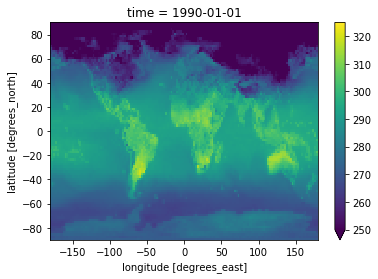

In [29]:
predicted.isel(time=0).plot(vmin=250, vmax=325)

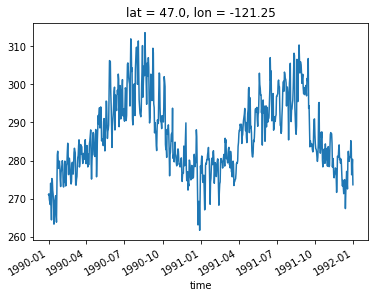

In [30]:
predicted.sel(lat=47, lon=-122, method='nearest').plot()